# Pre-Processing Pipeline

In [12]:
#Given pseudocode to grab the .h5 data file
import numpy as np
import h5py
from scipy import signal
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

with h5py.File("data/deepclean-1251335314-4097.h5", "r") as f:
    X = []
    for channel, timeseries in f.items():
        if channel == "H1:GDS-CALIB_STRAIN":
            y = timeseries[:]
        else:
            X.append(timeseries[:])
X = np.stack(X, axis=-1) # this will do channels last (as is typically done for Keras)
print(X.shape)
print(y.shape)

(16781312, 21)
(16781312,)


## Test Train Split

In [13]:
train_max_index = int(X.shape[0] * 4 / 5)

X_train = X[:train_max_index]
y_train = y[:train_max_index]

X_test = X[train_max_index:]
y_test = y[train_max_index:]

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(13425049, 21)
(13425049,)
(3356263, 21)
(3356263,)


## Batching (Train and Test)

(1638, 8192, 21)
(1638, 8192)
(409, 8192, 21)
(409, 8192)


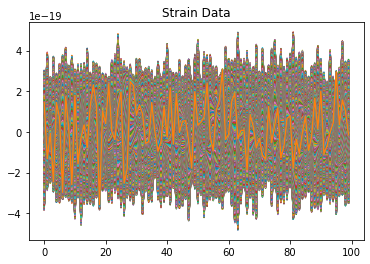

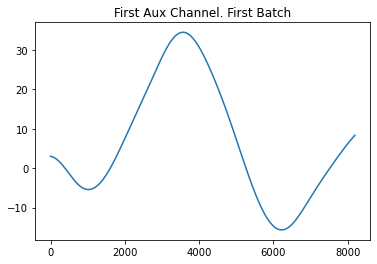

In [14]:
# then to construct inputs/outputs, you just
# slice windows from these two timeseries

# window_length = 2 to replicate 8192 data size from Figure 7
# window_length = 8 to replicate 32768 data size from Alec's suggestion
window_length = 8  # s
sample_rate = 4096 # Hz
window_size = window_length * sample_rate

# Train data batching
train_batches = int(X_train.shape[0]/window_size) 
X_train_batch, y_train_batch = [], []
for i in range(train_batches):
    idx = np.random.randint(X_train.shape[0] - window_size)
    X_train_batch.append(X_train[idx: idx + window_size])
    y_train_batch.append(y_train[idx: idx + window_size])

X_train_batch = np.stack(X_train_batch)
y_train_batch = np.stack(y_train_batch)

print(X_train_batch.shape)
print(y_train_batch.shape)



# Test data batching
# the idea here is the test data should be fixed and not randomized/shuffled
# so we're just going to grab as many contiguous slices of it as we can
test_batches = int(X_test.shape[0]/window_size)
X_test_batch, y_test_batch = [], []
for i in range(test_batches):
    idx = i * window_size
    X_test_batch.append(X_test[idx: idx + window_size])
    y_test_batch.append(y_test[idx: idx + window_size])

X_test_batch = np.stack(X_test_batch)
y_test_batch = np.stack(y_test_batch)

print(X_test_batch.shape)
print(y_test_batch.shape)


plt.plot(y_train_batch[0:100])
plt.title("Strain Data")
plt.savefig('strain_data.png')
plt.show()

plt.plot(X_train_batch[0][:,0])
plt.title("First Aux Channel. First Batch")
plt.savefig('First_Aux_Channel_First_Batch.png')
plt.show()


# Train Data
strain_data_train = y_train_batch
witness_data_train = X_train_batch

# Test Data
strain_data_test = y_test_batch
witness_data_test = X_test_batch

channels = 21

## Pre-processing data structure:

1. 8th Order Butterworth: Aliasing filter to mitigate power from outside the witnessed noise frequencies;

2. StandardScalar: Unit variance, Zero mean;

3. Windowing: Divide data into smaller overlapping windows;
 * Segment Length: 2.00, 4.00, or 8.00 Seconds;
 * 0.5 Hz => DFT of 2 Seconds;
    
4. Welches Method: 1 Second DFT overlap;

5. Training: Segment overlap [%] = 96.875

6. Testing: Segment overlap [%] = 50%

## PSD and CSD analysis

Finding pass-band frequencies via Cross Spectral Density Analysis


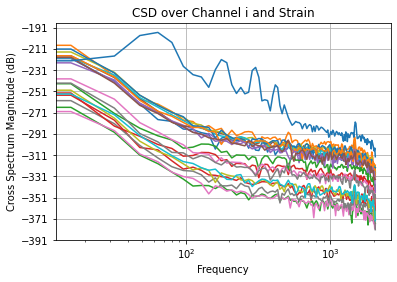

Finding pass-band frequencies via Cross Spectral Density Analysis


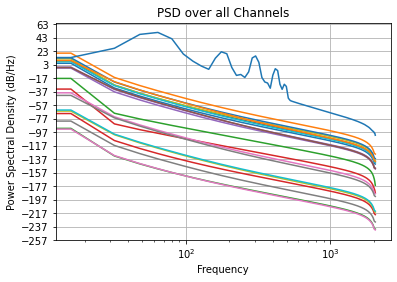

In [15]:
# 2.0: Butterworth
print("Finding pass-band frequencies via Cross Spectral Density Analysis")
# Find band pass values per channel

for i in range(0,21):
    plt.csd(X[:,i], y, Fs = 4096)
    plt.title("CSD over Channel i and Strain")

plt.xscale("log")
plt.savefig('CSD_over_Channel_i_and_Strain.png')
plt.show()


print("Finding pass-band frequencies via Cross Spectral Density Analysis")
## Find band pass values per channel
for i in range(0,21):
    plt.psd(X[:,i], Fs = 4096)
    plt.title("PSD over all Channels")

plt.xscale("log")
plt.savefig('PSD_over_all_Channels.png')
plt.show()

Building Butterworth Filter


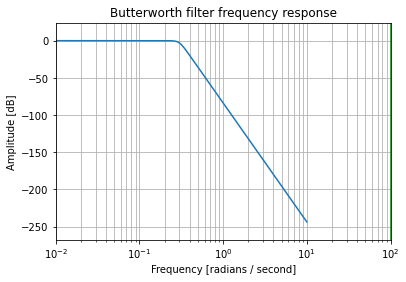

Butterworth filter built


In [16]:
print("Building Butterworth Filter")
N = 8 # order of butterworth filter

Wn = [0, 0.3] # Band-pass [low end, high end]
# Wn = [10, 100] # Band-pass [low end, high end]

filter_type = "bp"
fs = Wn[1]/2

b, a = signal.butter(N, Wn, filter_type, analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.savefig('Butterworth_filter_frequency_response.png')
plt.show()
butter_sos = signal.butter(N, Wn, filter_type, fs , output = 'sos')
print("Butterworth filter built")

Applying Butterworth to data
Train Witness shape: (1638, 8192, 21)
Test Witness shape: (409, 8192, 21)


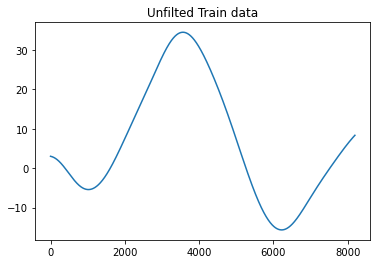

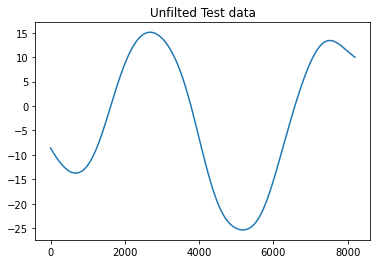

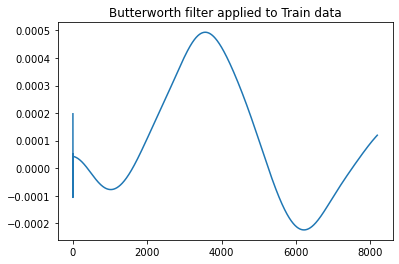

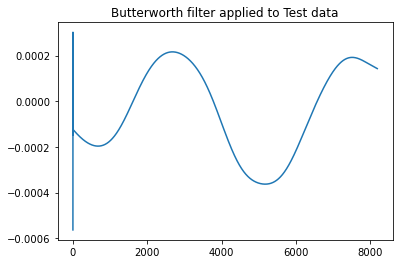

In [17]:
# 2.1: Apply butter_sos to data
print("Applying Butterworth to data")
print("Train Witness shape:", witness_data_train.shape)
print("Test Witness shape:", witness_data_test.shape)

# Pre-filtered plot
plt.plot(witness_data_train[0][:,0])
plt.title('Unfilted Train data')
plt.savefig('Unfilted_Train_data.png')
plt.show()

plt.plot(witness_data_test[0][:,0])
plt.title('Unfilted Test data')
plt.savefig('Unfilted_Test_data.png')
plt.show()

# Filter Train Data
for idx in range(len(witness_data_train)):
    for channel in range(channels):
        witness_data_train[idx][:, channel] = signal.sosfilt(butter_sos, witness_data_train[idx][:, channel])

# Filter Test Data
for idx in range(len(witness_data_test)):
    for channel in range(channels):
        witness_data_test[idx][:, channel] = signal.sosfilt(butter_sos, witness_data_test[idx][:, channel])        
        
# Post-filtered plot        
plt.plot(witness_data_train[0][:,0])
plt.title("Butterworth filter applied to Train data")
plt.savefig('Butterworth_filter_applied_to_Train_data.png')
plt.show()


plt.plot(witness_data_test[0][:,0])
plt.title("Butterworth filter applied to Test data")
plt.savefig('Butterworth_filter_applied_to_Test_data.png')
plt.show()

## 3: Standard Scalar (Z-score)

Normalization in progress


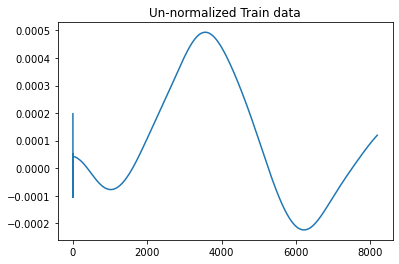

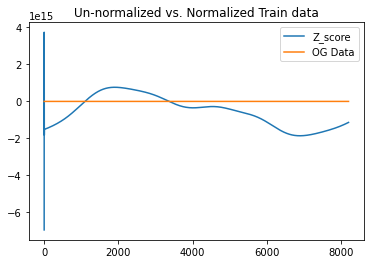

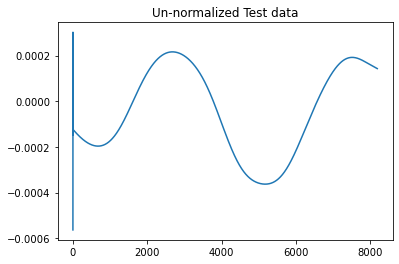

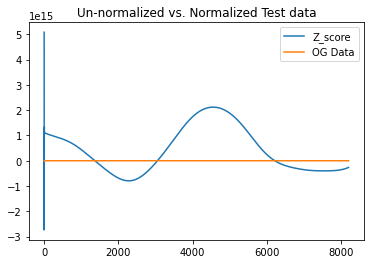

CNN Data Ready, Import witness_data
(1638, 8192, 21)
Normalization Complete


In [18]:
print("Normalization in progress")

# Train Data
plt.plot(witness_data_train[0][:,0])
plt.title("Un-normalized Train data")
plt.savefig('Un-normalized_Train_data.png')
plt.show()

scaler = StandardScaler()
strain_data_train = np.reshape(strain_data_train, (-1,1))

## For Post Processing
strain_mean_train = np.mean(strain_data_train)
strain_std_train = np.std(strain_data_train)


scaler.fit(strain_data_train)
strain_data_train = scaler.transform(strain_data_train)


test_1 = scaler.transform(np.reshape(witness_data_train[1][:,0], (-1,1)))
plt.plot(test_1, label = "Z_score")
plt.plot(witness_data_train[0][:,0], label = "OG Data")
plt.title("Un-normalized vs. Normalized Train data")
plt.legend()
plt.savefig('Un-normalized_vs_Normalized_Train_data.png')
plt.show()




# Test Data
plt.plot(witness_data_test[0][:,0])
plt.title("Un-normalized Test data")
plt.show()

scaler = StandardScaler()
strain_data_test = np.reshape(strain_data_test, (-1,1))

## For Post Processing
strain_mean_test = np.mean(strain_data_test)
strain_std_test = np.std(strain_data_test)


scaler.fit(strain_data_test)
strain_data_test = scaler.transform(strain_data_test)


test_1 = scaler.transform(np.reshape(witness_data_test[1][:,0], (-1,1)))
plt.plot(test_1, label = "Z_score")
plt.plot(witness_data_test[0][:,0], label = "OG Data")
plt.title("Un-normalized vs. Normalized Test data")
plt.savefig('Un-normalized_vs_Normalized_Test_data.png')
plt.legend()
plt.show()

print("CNN Data Ready, Import witness_data")
print(witness_data_train.shape)



print("Normalization Complete")

## 4: Windowing Parameters

In [19]:
# 4: Windowing
# Should match window_length from Batching cell
#window_length = 2
DFT_length = window_length
#sample_rate = 4096
#window_size = window_length * sample_rate
DFT_size = DFT_length * sample_rate
overlap_percent = 0.96875

## 5: Welch's Method and DFT

In [20]:
# 5: Welches Method
print("Applying Welch's Method")
window_type = 'hann'
nperseg_train = window_size
noverlap_train = window_size*(1-overlap_percent)
nfft = DFT_size
freq_data_train = []
freq_data_test = []

# Train Data
for batch in range(len(witness_data_train)):
    batch_data = []
    for channel in range(channels):
        welch_data = signal.welch(witness_data_train[batch][:, channel], sample_rate, window = 'hann')
        batch_data.append(welch_data[1])
    batch_data = np.stack(batch_data, axis = -1)
    freq_data_train.append(batch_data)
freq_data_train = np.stack(freq_data_train, axis = 0)

# Test data
for batch in range(len(witness_data_test)):
    batch_data = []
    for channel in range(channels):
        welch_data = signal.welch(witness_data_test[batch][:, channel], sample_rate, window = 'hann')
        batch_data.append(welch_data[1])
    batch_data = np.stack(batch_data, axis = -1)
    freq_data_test.append(batch_data)
freq_data_test = np.stack(freq_data_test, axis = 0)

print("Welch's Method Complete")


Applying Welch's Method
Welch's Method Complete


In [21]:
#Reshape Strain Data for Model Training

strain_data_train = np.reshape(strain_data_train, (X_train_batch.shape[0], window_size))
strain_data_test = np.reshape(strain_data_test, (X_test_batch.shape[0], window_size))

print(strain_data_train.shape, strain_data_test.shape)

(1638, 8192) (409, 8192)


## API Call to send data

In [22]:
def send_freq_data():
    """
    new_data == Spectral density data data,
    strain_data == GW processed data
    
    Used for loss function computaiton
    """
    return freq_data_train, strain_data_train, freq_data_test, strain_data_test

def send_time_data():
    """
    Train Data: 
    witness_data_train == filtered, and z_scored aux channel data,
    strain_data_train == GW processed data
    
    Test Data: 
    witness_data_test == filtered, and z_scored aux channel data,
    strain_data_test == GW processed data
    
    Used for CNN training. Not split yet.
    """
    return witness_data_train, strain_data_train, witness_data_test, strain_data_test


def send_post_processing_params():
    """
    Train Data
    strain_mean_train == mean of data used for z-score
    strain_std_train = std dev used for z-score
    
    Test Data
    strain_mean_test == mean of data used for z-score
    strain_std_test = std dev used for z-score
    
    Will be needed in post processing. Call function to return the old mean and std dev to reverse z-score
    """
    return strain_mean_train, strain_std_train, strain_mean_test, strain_std_test